In [23]:
from skopt import gp_minimize
from skopt import forest_minimize # Bayesian Optimization with RF as surrogate
from skopt import gbrt_minimize # Bayesian Optimization with GBM as surrogate
from skopt import Optimizer # for the optimization
from joblib import Parallel, delayed # for the parallelization
from skopt import dummy_minimize # for the randomized search
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
cv = KFold(n_splits=5, shuffle=True, random_state=2)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math


In [124]:
PC  = pd.read_excel('data.xlsx',sheet_name='RCCs')[['fck','av','b','wc','d','h','rf','rh','rv','fyt','fyh','fyv','Nc','Vexp']]
PC['vn']=PC['Vexp']/(PC['h'] * PC['b'])/PC['fck']*1000
PC['nn']=PC['Nc']/(PC['h'] * PC['b'])/PC['fck']*1000

X=PC[['fck','av','b','wc','d','h','rf','rh','rv','fyt','fyh','fyv','nn']]
y=PC['vn']
OUT_RANGE=(1,2)#important (better than (-1,1)) as I minimize the neg_mean_absolute_percentage_error
X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=OUT_RANGE)
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=2)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
import xgboost as xgb

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        #"num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("booster", ['gbtree', 'dart']),#, 'rf'
    }
    model = xgb.XGBRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-06-02 10:31:30,481] A new study created in memory with name: no-name-1bc865a4-0928-435f-86a8-e62a702c301f
[I 2024-06-02 10:31:38,955] Trial 0 finished with value: 0.09688767721740912 and parameters: {'n_estimators': 148, 'learning_rate': 0.0602041906675246, 'gamma': 36.46755990210687, 'max_depth': 49, 'booster': 'gbtree'}. Best is trial 0 with value: 0.09688767721740912.
[I 2024-06-02 10:31:39,224] Trial 14 finished with value: 0.05059190825527384 and parameters: {'n_estimators': 97, 'learning_rate': 0.07462418395244817, 'gamma': 0.01561073876183277, 'max_depth': 44, 'booster': 'dart'}. Best is trial 14 with value: 0.05059190825527384.
[I 2024-06-02 10:31:41,502] Trial 12 finished with value: 0.5400560327242805 and parameters: {'n_estimators': 41, 'learning_rate': 0.0037384809520740396, 'gamma': 32.31689444480287, 'max_depth': 22, 'booster': 'dart'}. Best is trial 14 with value: 0.05059190825527384.
[I 2024-06-02 10:31:42,479] Trial 8 finished with value: 0.09689722088737844 an

Best hyperparameters: {'n_estimators': 591, 'learning_rate': 0.04170714308438061, 'gamma': 0.01005162666293261, 'max_depth': 12, 'booster': 'gbtree'}
Best RMSE: 0.04813514976417696


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
aa=xgb.XGBRegressor(n_estimators=591, max_depth=12, learning_rate=0.04170714308438061, booster='gbtree', gamma=0.01005162666293261)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
print('MAPE',mean_absolute_percentage_error(y_test, aa.predict(X_test)))

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
print('MAPE',mean_absolute_percentage_error(y1_test, y1_pred))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
print('MAPE',mean_absolute_percentage_error(y1, data1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)

df.columns = ['fck','av','b','wc','d','h','rf','rh','rv','fyt','fyh','fyv','nn','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*PC['fck']
PC['V_pred']=PC['V_pred']*PC['fck']
filename = 'XGB_shear.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)


MAPE 1.017269160218278
MAPE 1.1324784559671808
MAPE 0.06378857026886209
Data exported to XGB_shear.xlsx


In [60]:
import catboost as cb
import optuna
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-06-25 22:52:43,550] A new study created in memory with name: no-name-7b3dca6c-9329-49d7-8522-8a785ed90ccb
[I 2024-06-25 22:54:47,740] Trial 14 finished with value: 0.056892588162645294 and parameters: {'iterations': 1363, 'learning_rate': 0.05115776313045964, 'depth': 1, 'subsample': 0.0645229366476055, 'colsample_bylevel': 0.4081055774705907, 'min_data_in_leaf': 26}. Best is trial 14 with value: 0.056892588162645294.
[I 2024-06-25 22:55:11,089] Trial 1 finished with value: 0.055406202733438825 and parameters: {'iterations': 744, 'learning_rate': 0.008750795167309483, 'depth': 12, 'subsample': 0.879383169973905, 'colsample_bylevel': 0.48957993702180724, 'min_data_in_leaf': 10}. Best is trial 1 with value: 0.055406202733438825.
[I 2024-06-25 22:55:11,613] Trial 6 finished with value: 0.044263765531294685 and parameters: {'iterations': 1536, 'learning_rate': 0.08032147044452012, 'depth': 12, 'subsample': 0.47280354970251864, 'colsample_bylevel': 0.08625175609283942, 'min_data_in_

In [125]:
import catboost as cb
aa=cb.CatBoostRegressor(iterations=1216,learning_rate=0.05444914168563233,depth=4,subsample=0.8737144278441203,colsample_bylevel=0.2816061259246872,min_data_in_leaf= 27)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
print('MAPE train',mean_absolute_percentage_error(y_test, aa.predict(X_test)))

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
print('MAPE test',mean_absolute_percentage_error(y1_test, y1_pred))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
print('MAPE',mean_absolute_percentage_error(y1, data1))

data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['fck','av','b','wc','d','h','rf','rh','rv','fyt','fyh','fyv','nn','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*PC['fck']
PC['V_pred']=PC['V_pred']*PC['fck']

filename = 'Cat_data.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)


#train vs test data
y1_pred = aa.predict(X_train)
X1=scaler.inverse_transform(X_train);y1=scaler_out.inverse_transform(y_train)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))

data=np.concatenate((data,data1),axis=1)
df2 = pd.DataFrame(data)
df2.columns = ['fck','av','b','wc','d','h','rf','rh','rv','fyt','fyh','fyv','nn','V_exp','V_pred'];PC=df2
PC['V_exp']=PC['V_exp']*PC['fck']
PC['V_pred']=PC['V_pred']*PC['fck']

filename = 'Cat_cor_train.xlsx'
df2.to_excel(filename, index=False)
print("Data exported to", filename)

y1_pred = aa.predict(X_test)
X1=scaler.inverse_transform(X_test);y1=scaler_out.inverse_transform(y_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))

data=np.concatenate((data,data1),axis=1)
df1 = pd.DataFrame(data)
df1.columns = ['fck','av','b','wc','d','h','rf','rh','rv','fyt','fyh','fyv','nn','V_exp','V_pred'];PC=df1
PC['V_exp']=PC['V_exp']*PC['fck']
PC['V_pred']=PC['V_pred']*PC['fck']

filename = 'Cat_cor_test.xlsx'
df1.to_excel(filename, index=False)
print("Data exported to", filename)


0:	learn: 0.1738948	total: 666us	remaining: 810ms
1:	learn: 0.1725749	total: 1.29ms	remaining: 785ms
2:	learn: 0.1688751	total: 1.64ms	remaining: 661ms
3:	learn: 0.1656577	total: 2.11ms	remaining: 640ms
4:	learn: 0.1625657	total: 2.57ms	remaining: 622ms
5:	learn: 0.1616524	total: 2.94ms	remaining: 592ms
6:	learn: 0.1594840	total: 3.25ms	remaining: 562ms
7:	learn: 0.1581257	total: 3.6ms	remaining: 544ms
8:	learn: 0.1558308	total: 3.91ms	remaining: 524ms
9:	learn: 0.1540988	total: 4.19ms	remaining: 505ms
10:	learn: 0.1521624	total: 4.47ms	remaining: 489ms
11:	learn: 0.1498366	total: 4.94ms	remaining: 496ms
12:	learn: 0.1484580	total: 5.28ms	remaining: 488ms
13:	learn: 0.1467940	total: 5.62ms	remaining: 483ms
14:	learn: 0.1446742	total: 5.97ms	remaining: 478ms
15:	learn: 0.1435499	total: 6.38ms	remaining: 478ms
16:	learn: 0.1423730	total: 6.71ms	remaining: 473ms
17:	learn: 0.1402788	total: 7.04ms	remaining: 469ms
18:	learn: 0.1395987	total: 7.34ms	remaining: 462ms
19:	learn: 0.1385535	tot

In [122]:
PC  = pd.read_excel('data.xlsx',sheet_name='RCDBs')[['fck','av','b','wb','d','h','rf','rh','rv','fyt','fyh','fyv','Vexp']]
PC['vn']=PC['Vexp']/(PC['h'] * PC['b'])/PC['fck']*1000

X=PC[['fck','av','b','wb','d','h','rf','rh','rv','fyt','fyh','fyv']]
y=PC['vn']
OUT_RANGE=(1,2)#important (better than (-1,1)) as I minimize the neg_mean_absolute_percentage_error
X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=OUT_RANGE)
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=2)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


In [3]:
import catboost as cb
import optuna
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-06-25 23:37:42,170] A new study created in memory with name: no-name-433d4bde-ed9c-454c-8080-b6c841fb86ee
[I 2024-06-25 23:37:51,460] Trial 0 finished with value: 0.054925798241518685 and parameters: {'iterations': 131, 'learning_rate': 0.05679444794622182, 'depth': 3, 'subsample': 0.9542496273627388, 'colsample_bylevel': 0.25796831681338317, 'min_data_in_leaf': 47}. Best is trial 0 with value: 0.054925798241518685.
[I 2024-06-25 23:38:38,443] Trial 3 finished with value: 0.0699977014160694 and parameters: {'iterations': 991, 'learning_rate': 0.00492652543363496, 'depth': 15, 'subsample': 0.9463241471473968, 'colsample_bylevel': 0.1050644262760099, 'min_data_in_leaf': 49}. Best is trial 0 with value: 0.054925798241518685.
[I 2024-06-25 23:44:51,004] Trial 9 finished with value: 0.07475452824334967 and parameters: {'iterations': 1839, 'learning_rate': 0.001325366826725487, 'depth': 10, 'subsample': 0.9240241157884814, 'colsample_bylevel': 0.15204694946049854, 'min_data_in_leaf':

Best hyperparameters: {'iterations': 1159, 'learning_rate': 0.08945562176938002, 'depth': 5, 'subsample': 0.5468225401482492, 'colsample_bylevel': 0.8352138338374154, 'min_data_in_leaf': 88}
Best RMSE: 0.03493962932342115


In [123]:
import catboost as cb
aa=cb.CatBoostRegressor(iterations=1159,learning_rate=0.08945562176938002,depth=5,subsample=0.5468225401482492,colsample_bylevel=0.8352138338374154,min_data_in_leaf= 88)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
print('MAPE train',mean_absolute_percentage_error(y_test, aa.predict(X_test)))

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
print('MAPE test',mean_absolute_percentage_error(y1_test, y1_pred))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
print('MAPE',mean_absolute_percentage_error(y1, data1))

data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['fck','av','b','wb','d','h','rf','rh','rv','fyt','fyh','fyv','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*PC['fck']
PC['V_pred']=PC['V_pred']*PC['fck']

filename = 'Cat_deep.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)


#train vs test data
y1_pred = aa.predict(X_train)
X1=scaler.inverse_transform(X_train);y1=scaler_out.inverse_transform(y_train)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))

data=np.concatenate((data,data1),axis=1)
df2 = pd.DataFrame(data)
df2.columns = ['fck','av','b','wb','d','h','rf','rh','rv','fyt','fyh','fyv','V_exp','V_pred'];PC=df2
PC['V_exp']=PC['V_exp']*PC['fck']
PC['V_pred']=PC['V_pred']*PC['fck']

filename = 'Cat_deep_train.xlsx'
df2.to_excel(filename, index=False)
print("Data exported to", filename)

y1_pred = aa.predict(X_test)
X1=scaler.inverse_transform(X_test);y1=scaler_out.inverse_transform(y_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))

data=np.concatenate((data,data1),axis=1)
df1 = pd.DataFrame(data)
df1.columns = ['fck','av','b','wb','d','h','rf','rh','rv','fyt','fyh','fyv','V_exp','V_pred'];
PC=df1
PC['V_exp']=PC['V_exp']*PC['fck']
PC['V_pred']=PC['V_pred']*PC['fck']

filename = 'Cat_deep_test.xlsx'
df1.to_excel(filename, index=False)
print("Data exported to", filename)

0:	learn: 0.1869060	total: 1ms	remaining: 1.16s
1:	learn: 0.1805656	total: 4.24ms	remaining: 2.45s
2:	learn: 0.1734966	total: 5.2ms	remaining: 2s
3:	learn: 0.1675883	total: 6.12ms	remaining: 1.77s
4:	learn: 0.1625581	total: 7.01ms	remaining: 1.62s
5:	learn: 0.1568278	total: 7.86ms	remaining: 1.51s
6:	learn: 0.1513107	total: 18.2ms	remaining: 2.99s
7:	learn: 0.1471138	total: 19.1ms	remaining: 2.74s
8:	learn: 0.1428841	total: 19.8ms	remaining: 2.52s
9:	learn: 0.1389874	total: 20.6ms	remaining: 2.36s
10:	learn: 0.1348881	total: 21.7ms	remaining: 2.27s
11:	learn: 0.1315172	total: 22.5ms	remaining: 2.15s
12:	learn: 0.1290351	total: 23.2ms	remaining: 2.05s
13:	learn: 0.1262798	total: 23.9ms	remaining: 1.96s
14:	learn: 0.1237371	total: 24.7ms	remaining: 1.88s
15:	learn: 0.1209020	total: 25.4ms	remaining: 1.81s
16:	learn: 0.1185455	total: 26.5ms	remaining: 1.78s
17:	learn: 0.1163796	total: 27.2ms	remaining: 1.73s
18:	learn: 0.1144004	total: 28ms	remaining: 1.68s
19:	learn: 0.1118893	total: 28.

In [140]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from tabulate import tabulate

# Read the data from the Excel file
PC  = pd.read_excel('data.xlsx',sheet_name='corbels')[['h','d','b','av','fck','rf','rh','rv','fyt','fyh','fyv','Vexp']]
PC['vn']=PC['Vexp']/(PC['h'] * PC['b'])/PC['fck']*1000
PC['a_d']=PC['av']/PC['d']

X=PC[['h','d','b','av','a_d','fck','rf','rh','rv','fyt','fyh','fyv']]
y=PC['vn']

# Create a list to store the statistical properties for each feature
features = ['h','d','b','av','a_d','fck','rf','rh','rv','fyt','fyh','fyv','vn']
X1=PC[features]
correlation_matrix = X1.corr()
print(correlation_matrix)
data_stats = pd.DataFrame()

# Calculate statistical properties for each feature
data_stats['Min'] = PC[features].min()
data_stats['Max'] = PC[features].max()
data_stats['Mean'] = PC[features].mean()
data_stats['Std'] = PC[features].std()
data_stats['Skewness'] = PC[features].apply(skew)
data_stats['Kurtosis'] = PC[features].apply(kurtosis)

# Display the statistical properties
print(data_stats)

            h         d         b        av       a_d       fck        rf  \
h    1.000000  0.996163  0.415047  0.394307 -0.372412 -0.145807 -0.044755   
d    0.996163  1.000000  0.426300  0.368933 -0.392004 -0.163289 -0.091174   
b    0.415047  0.426300  1.000000  0.222328 -0.164231 -0.179815 -0.212350   
av   0.394307  0.368933  0.222328  1.000000  0.632578 -0.058614  0.270991   
a_d -0.372412 -0.392004 -0.164231  0.632578  1.000000  0.049749  0.325056   
fck -0.145807 -0.163289 -0.179815 -0.058614  0.049749  1.000000  0.177710   
rf  -0.044755 -0.091174 -0.212350  0.270991  0.325056  0.177710  1.000000   
rh  -0.164809 -0.181633 -0.125115  0.129527  0.180687  0.285421  0.323107   
rv  -0.127452 -0.130808 -0.121043  0.334793  0.433124  0.120497  0.151701   
fyt -0.196551 -0.211517 -0.184784  0.180218  0.322010  0.262908 -0.057786   
fyh -0.236229 -0.237925 -0.085792  0.181858  0.255253  0.370128  0.058701   
fyv -0.142593 -0.143037 -0.100258  0.394118  0.495719  0.179050  0.091386   

In [141]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from tabulate import tabulate

# Read the data from the Excel file
PC  = pd.read_excel('data.xlsx',sheet_name='RCDBs')[['h','d','b','av','fck','rf','rh','rv','fyt','fyh','fyv','Vexp']]
PC['vn']=PC['Vexp']/(PC['h'] * PC['b'])/PC['fck']*1000
PC['a_d']=PC['av']/PC['d']

X=PC[['h','d','b','av','a_d','fck','rf','rh','rv','fyt','fyh','fyv']]
y=PC['vn']

# Create a list to store the statistical properties for each feature
features = ['h','d','b','av','a_d','fck','rf','rh','rv','fyt','fyh','fyv','vn']
X1=PC[features]
correlation_matrix = X1.corr()
print(correlation_matrix)
data_stats = pd.DataFrame()

# Calculate statistical properties for each feature
data_stats['Min'] = PC[features].min()
data_stats['Max'] = PC[features].max()
data_stats['Mean'] = PC[features].mean()
data_stats['Std'] = PC[features].std()
data_stats['Skewness'] = PC[features].apply(skew)
data_stats['Kurtosis'] = PC[features].apply(kurtosis)

# Display the statistical properties
print(data_stats)

            h         d         b        av       a_d       fck        rf  \
h    1.000000  0.996219  0.516489  0.769551 -0.084669 -0.017315 -0.105317   
d    0.996219  1.000000  0.501831  0.760441 -0.101788 -0.028839 -0.148025   
b    0.516489  0.501831  1.000000  0.656205  0.253189 -0.165862 -0.009553   
av   0.769551  0.760441  0.656205  1.000000  0.493058 -0.049047  0.023085   
a_d -0.084669 -0.101788  0.253189  0.493058  1.000000  0.029706  0.267693   
fck -0.017315 -0.028839 -0.165862 -0.049047  0.029706  1.000000  0.364470   
rf  -0.105317 -0.148025 -0.009553  0.023085  0.267693  0.364470  1.000000   
rh  -0.003630 -0.005332 -0.190294 -0.097703 -0.184549  0.062906  0.007049   
rv  -0.085474 -0.088590 -0.111051 -0.062332  0.013755  0.124089  0.201224   
fyt  0.107588  0.109529  0.168954  0.061029 -0.070707  0.147014 -0.181383   
fyh  0.111480  0.097422 -0.086039  0.091715 -0.044073  0.021854  0.027527   
fyv  0.002658 -0.002127  0.019173  0.084811  0.128848  0.181475  0.145880   

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from the Excel file
PC  = pd.read_excel('data.xlsx',sheet_name='corbels')[['fck','av','b','wc','d','h','rf','rh','rv','fyt','fyh','fyv','Nc','Vexp']]
PC['vn']=PC['Vexp']/(PC['h'] * PC['b'])/PC['fck']*1000
PC['nn']=PC['Nc']/(PC['h'] * PC['b'])/PC['fck']*1000

X=PC[['fck','av','b','wc','d','h','rf','rh','rv','fyt','fyh','fyv','nn']]
y=PC['vn']

features = ['h','b','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','vn']
X1=PC[features]

column_labels = ['$h$','$b$','$a/d$','$f^\\prime_c$', '$\\rho$', '$f_y$','$\\rho_v$', '$f_{yv}$','$\\rho_h$', '$f_{yh}$','$w_{tp}$','$w_{bp}$', '$v_n$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 13),)
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 11, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_shear.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()

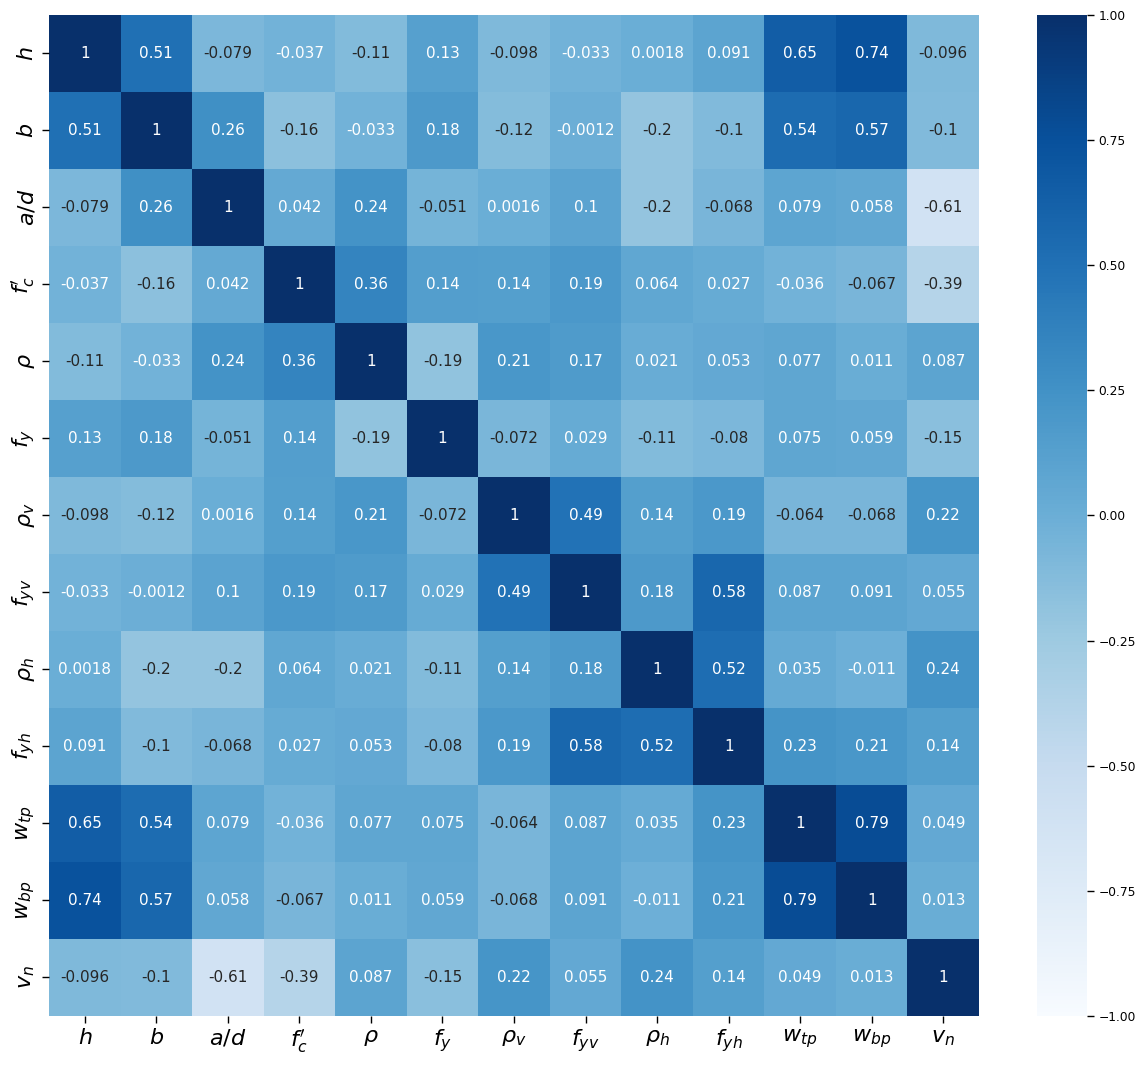

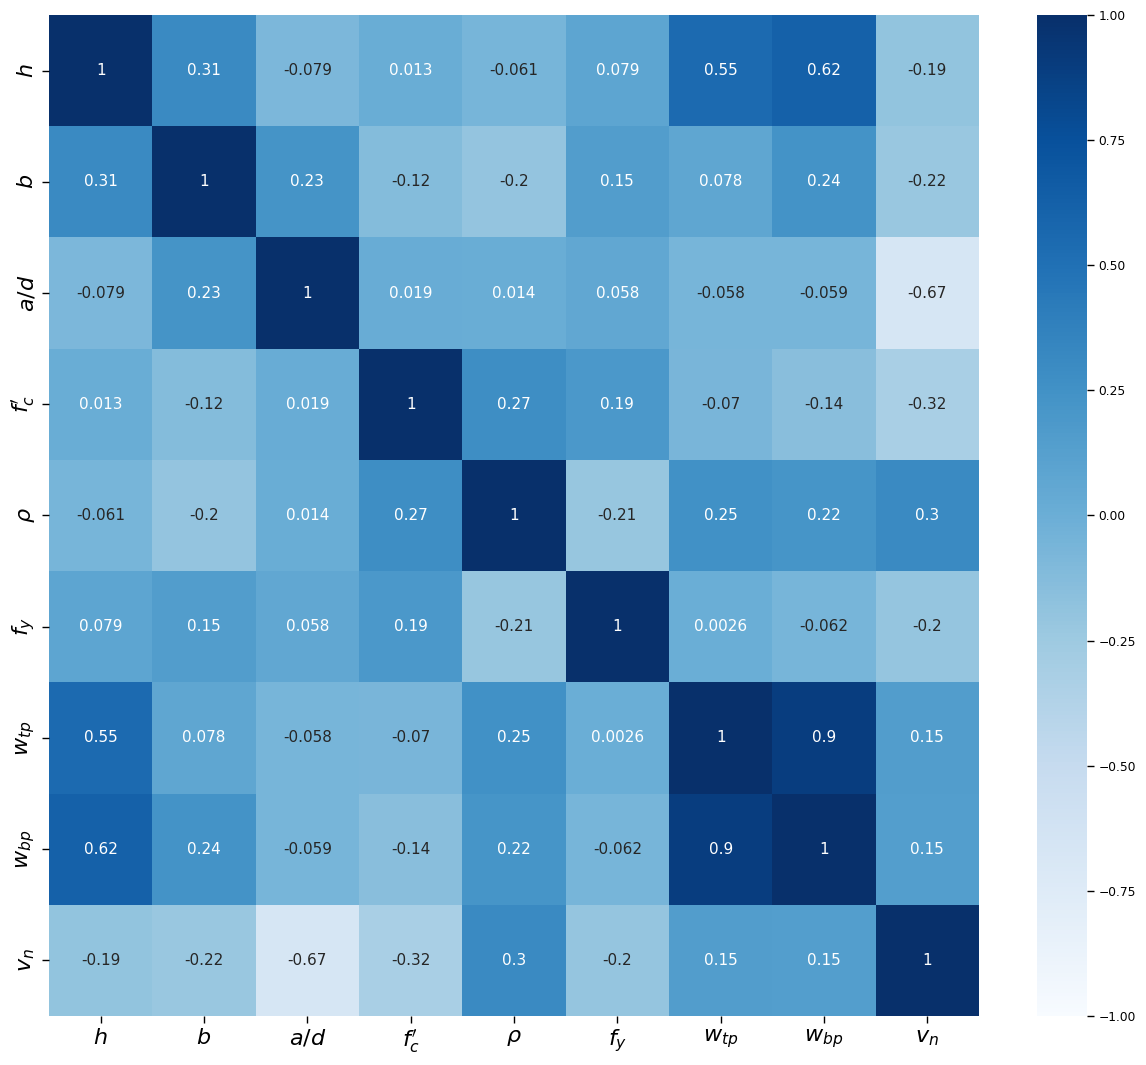

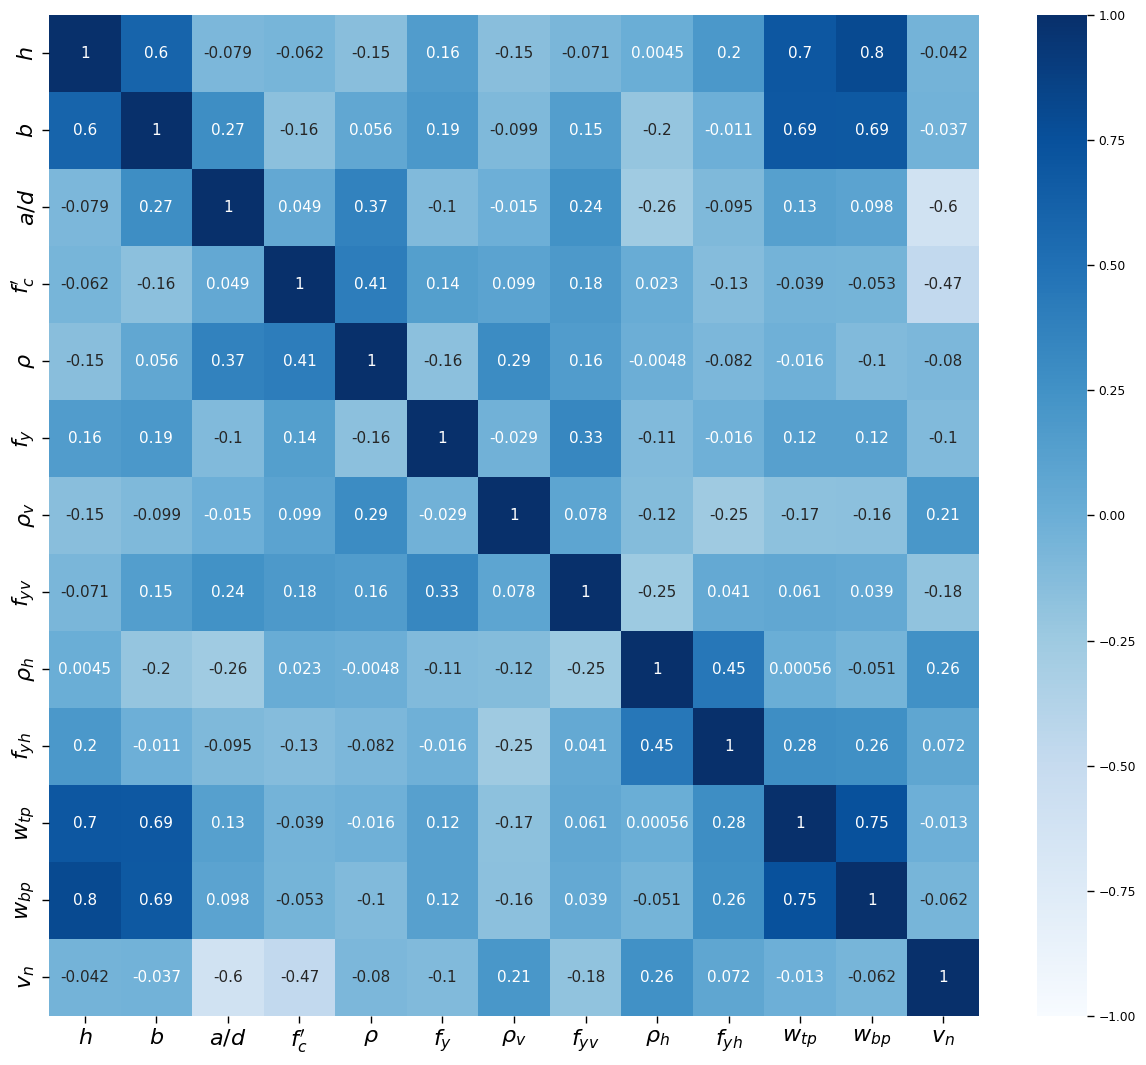

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from the Excel file
PC  = pd.read_excel('data.xlsx',sheet_name='corbels')[['h','b','a','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','b','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp']]
y=PC['vn']
features = ['h','b','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','vn']
X1=PC[features]

column_labels = ['$h$','$b$','$a/d$','$f^\\prime_c$', '$\\rho$', '$f_y$','$\\rho_v$', '$f_{yv}$','$\\rho_h$', '$f_{yh}$','$w_{tp}$','$w_{bp}$', '$v_n$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 13),)
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 11, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_shear.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from the Excel file
PC  = pd.read_excel('data.xlsx',sheet_name='corbels')[['h','b','a','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V']]
PC = PC[abs(PC['rho_v'] + PC['rho_h']) < 0.00000001]

PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','b','a_d','fck','rho','fy','w_tp','w_bp']]
y=PC['vn']
features = ['h','b','a_d','fck','rho','fy','w_tp','w_bp','vn']
X1=PC[features]

column_labels = ['$h$','$b$','$a/d$','$f^\\prime_c$', '$\\rho$', '$f_y$','$w_{tp}$','$w_{bp}$', '$v_n$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 13),)
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 11, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_shear_without.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from the Excel file
PC  = pd.read_excel('data.xlsx',sheet_name='corbels')[['h','b','a','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V']]
PC = PC[abs(PC['rho_v'] + PC['rho_h']) > 0.00000001]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','b','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp']]
y=PC['vn']
features = ['h','b','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','vn']
X1=PC[features]

column_labels = ['$h$','$b$','$a/d$','$f^\\prime_c$', '$\\rho$', '$f_y$','$\\rho_v$', '$f_{yv}$','$\\rho_h$', '$f_{yh}$','$w_{tp}$','$w_{bp}$', '$v_n$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 13),)
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 11, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_shear_with.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()

Russo

In [134]:
import math
def calculate_V_Russo(h,d,b_w,a,f_ck,rho,fy,rho_v, f_yv, rho_h, f_yh,w_tp,w_bp):
    n_rho=42.6/f_ck**0.5*rho;k=(n_rho**2.0+2.0*n_rho)**0.5-n_rho
    theta = 2.0*math.atan((((a/d)**2.0+(1.0-0.25*k**2.0))**0.5-1.0)/(a/d-0.5*k))
    f_r=min(105,max(10,f_ck))/ 105
    chi = 0.74 * f_r**3. - 1.28 * f_r**2. + 0.22 * f_r + 0.87
    V_Russo = 0.8 * (k * chi * f_ck * math.cos(theta) + 0. * a / d * rho_v * f_yv + 0.65 / math.tan(theta) * rho_h * f_yh) * b_w * d
    return V_Russo

rand_stat=42
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
PC  = pd.read_excel('data.xlsx',sheet_name='RCCs')[['fck','av','b','wc','d','h','rf','rh','rv','fyt','fyh','fyv','Nc','Vexp']]
PC['V']=PC['Vexp'];PC['a']=PC['av']+0*PC['wc']/4.0;PC['rho_h']=PC['rh'];PC['rho_v']=PC['rv'];PC['fy']=PC['fyt'];PC['w_tp']=PC['wc']/2.0;PC['w_bp']=PC['wc']/2.0
PC['rho']=PC['rf']-PC['Nc']/PC['fyt']/(PC['d'] * PC['b'])*1000

PC = PC.fillna(0)
X_normalized=PC[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp']]

y_normalized=PC['V']
#X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=1)
#Xc=np.concatenate((X_test, X_train), axis=0);yc=np.concatenate((y_test, y_train), axis=0)

yc = np.array(y_normalized); Xc = np.array(X_normalized)
V_Russo=np.zeros_like(yc)
for i in range(len(yc)):
    h,d,b_w,a,f_ck,rho,fy,rho_v, f_yv, rho_h, f_yh,w_tp,w_bp=Xc[i,:]
    V_Russo[i] = calculate_V_Russo(h,d,b_w,a,f_ck,rho,fy,rho_v, f_yv, rho_h, f_yh,w_tp,w_bp)/1000


print("Russo: Mean =", np.mean(yc/V_Russo), ", COV =", np.std(yc/V_Russo)/np.mean(yc/V_Russo))

PC['V_exp']=yc/PC['d']/PC['b']*1000.0;PC['V_pred']=V_Russo/PC['d']/PC['b']*1000.0;filename = 'Russo_cor.xlsx';PC.to_excel(filename, index=False)

Russo: Mean = 1.009535718200744 , COV = 0.1844905055507767


In [132]:
import math
def calculate_V_Russo(h,d,b_w,a,f_ck,rho,fy,rho_v, f_yv, rho_h, f_yh,w_tp,w_bp):
    n_rho=42.6/f_ck**0.5*rho;k=(n_rho**2.0+2.0*n_rho)**0.5-n_rho;w_s=k*d
    jd=(1-k/3)*d;theta = math.atan(jd/a)
    theta = math.atan((d-0.5*k*d*math.sin(theta))/(a-w_tp/2+0.5*k*d*math.cos(theta)))
    f_r=min(105,max(10,f_ck))/ 105;chi = 0.74 * f_r**3. - 1.28 * f_r**2. + 0.22 * f_r + 0.87
    V_Russo = 0.76 * (k * chi * f_ck * math.sin(theta) + 0.35 * a / d * rho_v * f_yv + 0.25 * math.tan(theta) * rho_h * f_yh) * b_w * d
    return V_Russo

rand_stat=42
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
PC  = pd.read_excel('data.xlsx',sheet_name='RCDBs')[['fck','av','b','wb','d','h','rf','rh','rv','fyt','fyh','fyv','wtp','wbp','Vexp']]
PC['V']=PC['Vexp'];PC['a']=PC['av'];PC['rho_h']=PC['rh'];PC['rho_v']=PC['rv'];PC['fy']=PC['fyt'];PC['rho']=PC['rf']

PC = PC.fillna(0)
X_normalized=PC[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','wtp','wbp']]

y_normalized=PC['V']
#X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=1)
#Xc=np.concatenate((X_test, X_train), axis=0);yc=np.concatenate((y_test, y_train), axis=0)

yc = np.array(y_normalized); Xc = np.array(X_normalized)
V_Russo=np.zeros_like(yc)
for i in range(len(yc)):
    h,d,b_w,a,f_ck,rho,fy,rho_v, f_yv, rho_h, f_yh,w_tp,w_bp=Xc[i,:]
    V_Russo[i] = calculate_V_Russo(h,d,b_w,a,f_ck,rho,fy,rho_v, f_yv, rho_h, f_yh,w_tp,w_bp)/1000


print("Russo: Mean =", np.mean(yc/V_Russo), ", COV =", np.std(yc/V_Russo)/np.mean(yc/V_Russo))

PC['V_exp']=yc/PC['d']/PC['b']*1000.0;PC['V_pred']=V_Russo/PC['d']/PC['b']*1000.0;filename = 'Russo_deep.xlsx';PC.to_excel(filename, index=False)

Russo: Mean = 0.9791214873744324 , COV = 0.1847682237388136


MIST

In [52]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
PC  = pd.read_excel('data.xlsx',sheet_name='RCCs')[['fck','av','b','wc','d','h','rf','rh','rv','fyt','fyh','fyv','Nc','Vexp']]
PC['rho']=PC['rf']-PC['Nc']/PC['fyt']/(PC['d'] * PC['b'])*1000
PC['s1']=PC['rh']*PC['fyh']/PC['fck'];PC['s2']=PC['rv']*PC['fyv']/PC['fck'];PC['a_d']=(PC['av']+PC['wc']/4.0)/PC['d']
PC['vn']=PC['Vexp']/(PC['d'] * PC['b'])/PC['fck']*1000

n_rho=42.6/PC['fck']**0.5*PC['rho'];k=(n_rho**2.0+2.0*n_rho)**0.5-n_rho;jd_a=(1.0-k/3.0)/PC['a_d']#*0.83
theta = np.arctan(jd_a);PC['t_th']=jd_a;PC['s_th']=np.sin(theta)
PC['s1_t']=PC['s1']*jd_a #np.tan(theta)
PC['a']=((k**2.0+(PC['wc']/2.0/PC['d'])**2.0)**0.5)*PC['s_th']
PC['br']=(PC['rho']*PC['fyt']+0.5*PC['fck']**0.5*2.0*(PC['h']/PC['d']-1.0))/PC['fck']*jd_a

X_normalized=PC[['s1_t','s2','a','br','a_d','fck','rho']]
y_normalized=PC['vn']
y = np.array(y_normalized); X = np.array(X_normalized)

from scipy.optimize import minimize
def eqn(parameters, X):
    s1_t,s2,aa,br,a_d,fck,rho=X[:,0],X[:,1],X[:,2],X[:,3],X[:,4],X[:,5],X[:,6]
    a,b,c,d,e= np.array(parameters)
    #1.039,0.847-1.0,2.973,0.389,0.215
    af=a*fck**(-1.0*b)*aa
    bf=c*br
    cf=s1_t*d+e*s2
    return  np.minimum(af*bf/(af+bf+0.000000000000001),0.85*aa)+cf
a=[1.039,1.0-0.847,2.973,0.389,0.215]
PC['pred']=eqn(a, X)
aa=PC['vn']/PC['pred'];PC['V_exp']=PC['vn']*PC['fck'];PC['V_pred']=PC['pred']*PC['fck']#V/bd
print(np.std(aa)/np.mean(aa), np.mean(aa))
filename = 'MIST_cor.xlsx';PC.to_excel(filename, index=False)

0.1618005312354256 1.0164187464074004


In [53]:
PC  = pd.read_excel('data.xlsx',sheet_name='RCDBs')[['fck','av','b','wb','d','h','rf','rh','rv','fyt','fyh','fyv','Vexp']]
PC['rho']=PC['rf']
PC['s1']=PC['rh']*PC['fyh']/PC['fck'];PC['s2']=PC['rv']*PC['fyv']/PC['fck'];PC['a_d']=PC['av']/PC['d']
PC['vn']=PC['Vexp']/(PC['d'] * PC['b'])/PC['fck']*1000

n_rho=42.6/PC['fck']**0.5*PC['rho'];k=(n_rho**2.0+2.0*n_rho)**0.5-n_rho;jd_a=(1.0-k/3.0)/PC['a_d']#*0.83
theta = np.arctan(jd_a)
PC['t_th']=jd_a;PC['s_th']=np.sin(theta)
PC['s1_t']=PC['s1']*jd_a #np.tan(theta)
PC['a']=((k**2.0+(PC['wb']/PC['d'])**2.0)**0.5)*PC['s_th']
PC['br']=(PC['rho']*PC['fyt']+0.5*PC['fck']**0.5*2.0*(PC['h']/PC['d']-1.0))/PC['fck']*jd_a

X_normalized=PC[['s1_t','s2','a','br','a_d','fck','rho']]
y_normalized=PC['vn']
y = np.array(y_normalized); X = np.array(X_normalized)

from scipy.optimize import minimize
def eqn(parameters, X):
    s1_t,s2,aa,br,a_d,fck,rho=X[:,0],X[:,1],X[:,2],X[:,3],X[:,4],X[:,5],X[:,6]
    a,b,c,d,e= np.array(parameters)
    af=a*fck**(-1.0*b)*aa
    bf=c*br
    cf=s1_t*d+e*s2
    return  np.minimum(af*bf/(af+bf+0.000000000000001),0.85*aa)+cf
a=[1.864,1.0-0.704,3.512,0.161,0.153]
PC['pred']=eqn(a, X)
aa=PC['vn']/PC['pred'];PC['V_exp']=PC['vn']*PC['fck'];PC['V_pred']=PC['pred']*PC['fck']#V/bd
print(np.std(aa)/np.mean(aa), np.mean(aa))
filename = 'MIST_deep.xlsx';PC.to_excel(filename, index=False)

0.1524463646898095 0.9889952006760206


proposed

In [98]:
import pandas as pd
import numpy as np
PC  = pd.read_excel('data.xlsx',sheet_name='RCCs')[['fck','av','b','wc','d','h','rf','rh','rv','fyt','fyh','fyv','Nc','Vexp']]
PC['rho']=PC['rf']-PC['Nc']/PC['fyt']/(PC['d'] * PC['b'])*1000
PC['s1']=PC['rh']*PC['fyh']/PC['fck'];PC['s2']=PC['rv']*PC['fyv']/PC['fck'];PC['a_d']=PC['av']/PC['d']
PC['vn']=PC['Vexp']/(PC['d'] * PC['b'])/PC['fck']*1000

n_rho=42.6/PC['fck']**0.5*PC['rho'];k=(n_rho**2.0+2.0*n_rho)**0.5-n_rho;jd_a=(1.0-k/3.0)/PC['a_d']#*0.83
theta = np.arctan(jd_a);PC['t_th']=jd_a;PC['s_th']=np.sin(theta)
PC['s1_t']=PC['s1']*jd_a #np.tan(theta)
PC['ks']=(k**2.0+(PC['wc']/2.0/PC['d'])**2.0)**0.5
PC['re']=(PC['rho']*PC['fyt'])/PC['fck']

X_normalized=PC[['s1','s2','ks','re','fck','s_th','t_th']]
y_normalized=PC['vn']
y = np.array(y_normalized); X = np.array(X_normalized)

def eqn(X):
    s1,s2,ks,re,fck,s,t=X[:,0],X[:,1],X[:,2],X[:,3],X[:,4],X[:,5],X[:,6]
    af=0.8**(fck/60.0+3.1)*ks**0.78*s;bf=3.0*re*t
    cf=0.17*s1**0.83*t+0.27*s2
    return  af*bf/(af+bf+0.000000000000001)+cf
PC['pred']=eqn(X)
aa=PC['vn']/PC['pred'];PC['V_exp']=PC['vn']*PC['fck'];PC['V_pred']=PC['pred']*PC['fck']#V/bd
print(np.std(aa)/np.mean(aa), np.mean(aa))
#filename = 'prop_cor.xlsx';PC.to_excel(filename, index=False)

0.1494823908959507 1.0041167153289552


In [99]:
V_train, V_test, Vp_train, Vp_test = train_test_split(PC['V_exp'], PC['V_pred'], test_size=0.2, random_state=6)
data=np.concatenate((V_train.values.reshape(-1, 1),Vp_train.values.reshape(-1, 1)),axis=1)
df = pd.DataFrame(data)
df.columns = ['V_exp','V_pred']
aa=df['V_exp']/df['V_pred'];print(np.std(aa)/np.mean(aa), np.mean(aa))
filename = 'prop_cor_train.xlsx';df.to_excel(filename, index=False);print("Data exported to", filename)
data=np.concatenate((V_test.values.reshape(-1, 1),Vp_test.values.reshape(-1, 1)),axis=1)
df = pd.DataFrame(data)
df.columns = ['V_exp','V_pred']
aa=df['V_exp']/df['V_pred'];print(np.std(aa)/np.mean(aa), np.mean(aa))
filename = 'prop_cor_test.xlsx';df.to_excel(filename, index=False);print("Data exported to", filename)

V=np.concatenate((V_test, V_train), axis=0);Vp=np.concatenate((Vp_test, Vp_train), axis=0)
df = pd.DataFrame(data)
df.columns = ['V_exp','V_pred']
filename = 'prop_cor.xlsx';PC.to_excel(filename, index=False)

0.14633735731481523 1.0173504650145644
Data exported to prop_cor_train.xlsx
0.15060365639116774 0.9518875165697511
Data exported to prop_cor_test.xlsx


In [100]:
import pandas as pd
import numpy as np
PC  = pd.read_excel('data.xlsx',sheet_name='RCDBs')[['fck','av','b','wb','d','h','rf','rh','rv','fyt','fyh','fyv','Vexp']]
PC['rho']=PC['rf'];PC['s1']=PC['rh']*PC['fyh']/PC['fck'];PC['s2']=PC['rv']*PC['fyv']/PC['fck'];PC['a_d']=PC['av']/PC['d']
PC['vn']=PC['Vexp']/(PC['d'] * PC['b'])/PC['fck']*1000

n_rho=42.6/PC['fck']**0.5*PC['rho'];k=(n_rho**2.0+2.0*n_rho)**0.5-n_rho;jd_a=(1.0-k/3.0)/PC['a_d']#*0.83
theta = np.arctan(jd_a);PC['t_th']=jd_a;PC['s_th']=np.sin(theta)
PC['s1_t']=PC['s1']*jd_a #np.tan(theta)
PC['ks']=(k**2.0+(PC['wb']/PC['d'])**2.0)**0.5
PC['re']=(PC['rho']*PC['fyt'])/PC['fck']

X_normalized=PC[['s1','s2','ks','re','fck','s_th','t_th']]
y_normalized=PC['vn']
y = np.array(y_normalized); X = np.array(X_normalized)

def eqn(X):
    s1,s2,ks,re,fck,s,t=X[:,0],X[:,1],X[:,2],X[:,3],X[:,4],X[:,5],X[:,6]
    af=0.8**(fck/30.0-0.15)*ks**1.1*s;bf=1.6*re**0.7*t
    cf=0.14*s1*t+0.31*s2
    return  af*bf/(af+bf+0.000000000000001)+cf
PC['pred']=eqn(X)
aa=PC['vn']/PC['pred'];PC['V_exp']=PC['vn']*PC['fck'];PC['V_pred']=PC['pred']*PC['fck']#V/bd
print(np.std(aa)/np.mean(aa), np.mean(aa))
#filename = 'prop_deep.xlsx';PC.to_excel(filename, index=False)

0.1455147198418297 0.9993440334983966


In [101]:
V_train, V_test, Vp_train, Vp_test = train_test_split(PC['V_exp'], PC['V_pred'], test_size=0.2, random_state=4)
data=np.concatenate((V_train.values.reshape(-1, 1),Vp_train.values.reshape(-1, 1)),axis=1)
df = pd.DataFrame(data)
df.columns = ['V_exp','V_pred']
aa=df['V_exp']/df['V_pred'];print(np.std(aa)/np.mean(aa), np.mean(aa))
filename = 'prop_deep_train.xlsx';df.to_excel(filename, index=False);print("Data exported to", filename)
data=np.concatenate((V_test.values.reshape(-1, 1),Vp_test.values.reshape(-1, 1)),axis=1)
df = pd.DataFrame(data)
df.columns = ['V_exp','V_pred']
aa=df['V_exp']/df['V_pred'];print(np.std(aa)/np.mean(aa), np.mean(aa))
filename = 'prop_deep_test.xlsx';df.to_excel(filename, index=False);print("Data exported to", filename)

V=np.concatenate((V_test, V_train), axis=0);Vp=np.concatenate((Vp_test, Vp_train), axis=0)
df = pd.DataFrame(data)
df.columns = ['V_exp','V_pred']
filename = 'prop_deep.xlsx';PC.to_excel(filename, index=False)

0.14517664717043638 0.9997768637101946
Data exported to prop_deep_train.xlsx
0.14685195191390446 0.9976127126512043
Data exported to prop_deep_test.xlsx
